# LSTM track finder for 2D toy data in PyTorch

Here, I'm going to get familiar with PyTorch by reproducing the models in LSTM_Toy2D.ipynb.

In [1]:
# Select a GPU first
cuda = True
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from __future__ import print_function

from timeit import default_timer as timer
from functools import partial

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from data import generate_straight_tracks, generate_uniform_noise, generate_track_bkg
from drawing import draw_2d_event, draw_2d_input_and_pred

%matplotlib notebook

In [3]:
torch.__version__

'0.2.0_2'

## Prepare some data

In [4]:
# Detector parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

# Data config
n_bkg_tracks = 5
noise_prob = 0

In [5]:
def generate_data(num_events, det_shape, num_bkg_tracks, noise_prob,
                  seed_size=0, binary=True):
    # Generate signal tracks
    sig_tracks = generate_straight_tracks(num_events, det_shape).astype(np.float32)
    # Generate track background
    bkg_tracks = generate_track_bkg(num_events, det_shape,
                                    tracks_per_event=num_bkg_tracks,
                                    skip_layers=seed_size).astype(np.float32)
    # Generate noise background
    noise = generate_uniform_noise(num_events, det_shape,
                                   prob=noise_prob).astype(np.float32)
    # Combine into full events
    events = sig_tracks + bkg_tracks + noise
    if binary:
        events[events > 1] = 1

    return events, sig_tracks

## LSTM simple pixel classifier

This is the traditional model we've done before in keras, but now in pytorch.

In [6]:
# CUDA memory allocations
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [23]:
class LSTMTrackFinder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_lstm_layers=1):
        super(LSTMTrackFinder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        h = (create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size),
             create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies independently across layers.
        x = self.fc(x.contiguous().view(-1, x.size(-1))).view(input_size)
        return x

In [36]:
def cost_function(logits, labels):
    # Flatten the batch and detector layer dimensions
    flat_logits = logits.view(-1, logits.size(-1))
    flat_labels = labels.view(-1)
    return F.cross_entropy(flat_logits, flat_labels)

def logits_to_probs(logits):
    size = logits.size()
    return F.softmax(logits.view(-1, size[-1])).view(size)

def batch_generator(**kwargs):
    while True:
        events, tracks = generate_data(**kwargs)
        inputs = np_to_torch(events)
        labels = np_to_torch(tracks.argmax(axis=2))
        yield inputs, labels

def train_step(model, inputs, targets, optimizer, cost_func):
    model.zero_grad()
    outputs = model(inputs)
    loss = cost_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def calc_accuracy(outputs, labels):
    matches = (outputs.max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

In [27]:
# Model config
hidden_dim = 100
n_lstm_layers = 1

# Train config
n_epochs = 64
n_batches = 512
batch_size = 128

In [28]:
epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

65536 samples per epoch
4194304 total samples for training


In [29]:
%%time
# Create the model and optimizer
model = LSTMTrackFinder(det_width, hidden_dim, n_lstm_layers=n_lstm_layers)
optimizer = torch.optim.Adam(model.parameters())

if cuda: model.cuda()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

LSTMTrackFinder (
  (lstm): LSTM(50, 100, batch_first=True)
  (fc): Linear (100 -> 50)
)
Parameters: 65850
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.88 ms


In [35]:
# Training set batcher
train_batcher = batch_generator(
    num_events=batch_size, det_shape=det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_input, batch_labels = next(train_batcher)
        sum_loss += train_step(model, batch_input, batch_labels, optimizer, cost_function)
    
    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 2.348 time 50.0789s
Epoch 1
  average loss 1.216 time 12.1733s
Epoch 2
  average loss 0.874 time 12.1841s
Epoch 3
  average loss 0.751 time 12.1849s
Epoch 4
  average loss 0.615 time 12.189s
Epoch 5
  average loss 0.541 time 12.1874s
Epoch 6
  average loss 0.491 time 12.1897s
Epoch 7
  average loss 0.453 time 12.1252s
Epoch 8
  average loss 0.422 time 12.0689s
Epoch 9
  average loss 0.407 time 12.064s
Epoch 10
  average loss 0.373 time 12.0587s
Epoch 11
  average loss 0.361 time 12.0475s
Epoch 12
  average loss 0.355 time 12.0244s
Epoch 13
  average loss 0.340 time 11.9655s
Epoch 14
  average loss 0.324 time 12.0037s
Epoch 15
  average loss 0.314 time 12.0056s
Epoch 16
  average loss 0.307 time 12.0349s
Epoch 17
  average loss 0.303 time 12.0385s
Epoch 18
  average loss 0.289 time 12.0392s
Epoch 19
  average loss 0.284 time 12.0319s
Epoch 20
  average loss 0.273 time 12.2052s
Epoch 21
  average loss 0.277 time 12.3401s
Epoch 22
  average loss 0.270 time 12.3357s


<IPython.core.display.Javascript object>


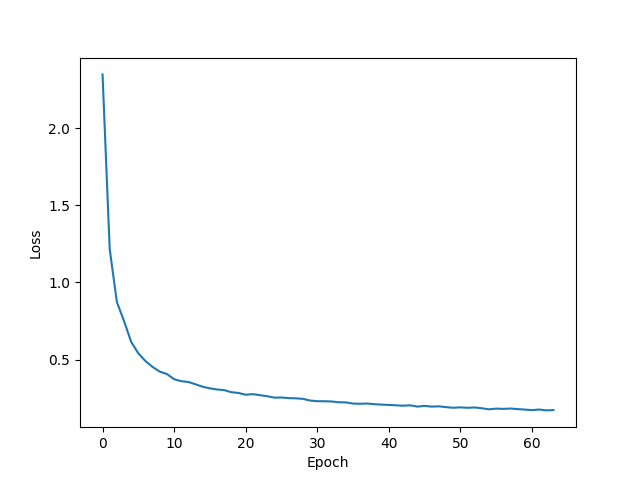

In [37]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

### Evaluate a test set

In [38]:
# Generate a test set
n_test = 10240
test_events, test_tracks = generate_data(
    n_test, det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)
test_input = np_to_torch(test_events)
test_labels = np_to_torch(test_tracks.argmax(axis=2))

In [42]:
# Calculate test set metrics
model.eval()
test_logits = model(test_input)
test_preds = logits_to_probs(test_logits)
test_loss = cost_function(test_logits, test_labels)

print('Final test loss', test_loss.data[0])
print('Pixel classification accuracy', calc_accuracy(test_preds, test_labels))
print('Hit classification accuracy', calc_accuracy(test_preds * test_input, test_labels))

Final test loss 0.169587314129
Pixel classification accuracy 0.93880078125
Hit classification accuracy 0.938982421875


<IPython.core.display.Javascript object>


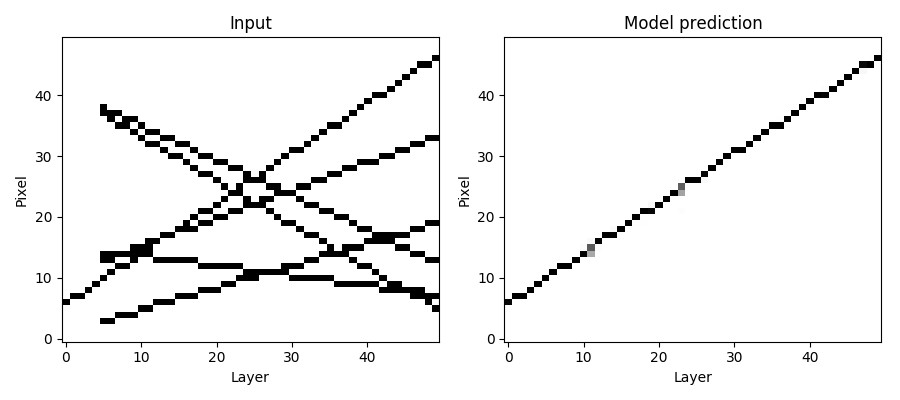

<IPython.core.display.Javascript object>


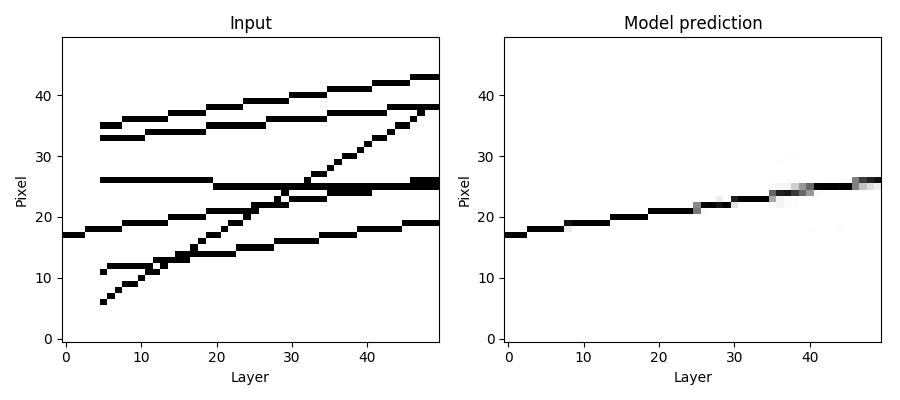

<IPython.core.display.Javascript object>


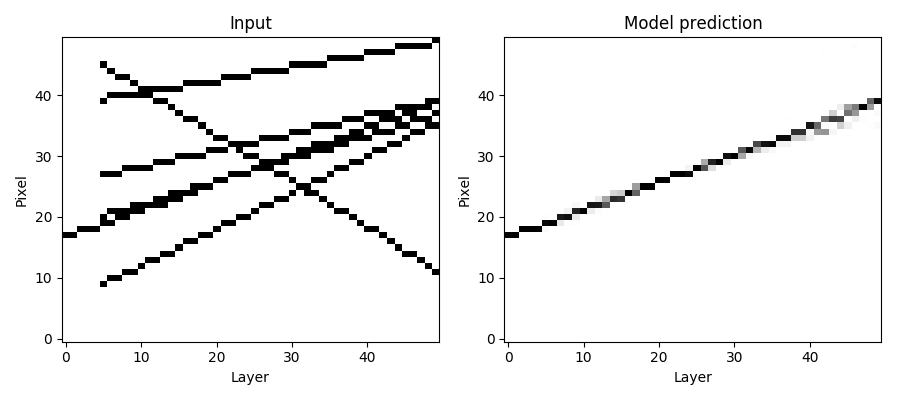

In [46]:
# Draw an event
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test_events[i], torch_to_np(test_preds[i]), cmap='gray_r');

## Filter model

New approach. In this model, at each layer the data is combined with a prior guess (from the seed or from extrapolation) to improve its state estimate. The output is split into a decoder which gives the final prediction on the current layer, and an extrapolator which produces the guess for the next layer.

In [14]:
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x, volatile=False: Variable(torch.from_numpy(x), volatile=volatile).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [47]:
class FilterTracker(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(FilterTracker, self).__init__()
        self.encoder = nn.Linear(input_dim*2, hidden_dim)
        self.lstm = nn.LSTMCell(hidden_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.extrapolator = nn.Linear(hidden_dim, input_dim)
    
    def init_hidden_state(self, batch_size):
        return (create_tensor_var(batch_size, self.lstm.hidden_size),
                create_tensor_var(batch_size, self.lstm.hidden_size))
    
    def step(self, x, prior, h, c):
        """Encode data and prior and iterate the LSTM"""
        z = F.sigmoid(self.encoder(torch.cat([x, prior], dim=1)))
        return self.lstm(z, (h, c))
    
    def forward(self, inputs):
        x, seed = inputs
        input_size = x.size()
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(input_size[0])
        # Two sets of outputs: forward-predictions and final-predictions
        fwd_preds, fin_preds = [seed[:,0]], []
        
        # Loop over seed layers
        for i in range(seed.size(1)):
            # Iterate the model using the seed as the prior
            h, c = self.step(x[:,i], seed[:,i], h, c)
            fin_preds.append(self.decoder(h))
            fwd_preds.append(self.extrapolator(h))
        
        # Loop over layers until last
        for i in range(seed.size(1), input_size[1] - 1):
            # Iterate the model using the forward-prediction as prior
            prior = F.softmax(fwd_preds[-1])
            h, c = self.step(x[:,i], prior, h, c)
            fin_preds.append(self.decoder(h))
            fwd_preds.append(self.extrapolator(h))
        
        # Handle final layer; no extrapolation needed
        prior = F.softmax(fwd_preds[-1])
        h, c = self.step(x[:,-1], prior, h, c)
        fin_preds.append(self.decoder(h))
        
        # Stack the outputs together
        return torch.stack(fwd_preds, dim=1), torch.stack(fin_preds, dim=1)

In [48]:
def cost_function(outputs, labels, loss_weights):
    # Flatten the batch and detector layer dimensions
    flat_logits = [o.view(-1, o.size(-1)) for o in outputs]
    labels = labels.view(-1)
    # Compute the losses and sum them
    losses = [F.cross_entropy(l, labels) for l in flat_logits]
    return sum(loss*w for (loss, w) in zip(losses, loss_weights))

def logits_to_probs(logits):
    size = logits.size()
    return F.softmax(logits.view(-1, size[-1])).view(size)

def batch_generator(seed_size, **kwargs):
    while True:
        events, tracks = generate_data(**kwargs)
        inputs = np_to_torch(events)
        seeds = np_to_torch(tracks[:,:seed_size])
        labels = np_to_torch(tracks.argmax(axis=2))
        yield (inputs, seeds), labels
        
def train_step(model, inputs, targets, optimizer, cost_func):
    model.zero_grad()
    outputs = model(inputs)
    loss = cost_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def calc_accuracy(outputs, labels):
    matches = (outputs.max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

In [53]:
# Model config
hidden_dim = 100

# Train config
n_epochs = 64
n_batches = 512
batch_size = 256
fwd_frac = 0.5
loss_weights = [fwd_frac, 1 - fwd_frac]

epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

131072 samples per epoch
8388608 total samples for training


In [54]:
%%time

# Create the model and optimizer
model3 = FilterTracker(det_width, hidden_dim)
optimizer = torch.optim.Adam(model3.parameters())

if cuda: model3.cuda()
print(model3)
print('Parameters:', sum(param.numel() for param in model3.parameters()))

FilterTracker (
  (encoder): Linear (100 -> 100)
  (lstm): LSTMCell(100, 100)
  (decoder): Linear (100 -> 50)
  (extrapolator): Linear (100 -> 50)
)
Parameters: 101000
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.84 ms


In [ ]:
# Training set batcher
train3_batcher = batch_generator(
    num_events=batch_size, det_shape=det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_input, batch_labels = next(train3_batcher)
        sum_loss += train_step(model3, batch_input, batch_labels, optimizer,
                               partial(cost_function, loss_weights=loss_weights))

    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 3.244 time 64.2935s
Epoch 1
  average loss 2.727 time 64.3953s
Epoch 2
  average loss 2.343 time 64.4651s
Epoch 3
  average loss 1.979 time 64.1097s
Epoch 4
  average loss 1.802 time 64.4084s
Epoch 5
  average loss 1.682 time 64.6009s
Epoch 6
  average loss 1.564 time 64.4651s
Epoch 7
  average loss 1.471 time 65.0598s
Epoch 8
  average loss 1.409 time 66.0047s
Epoch 9
  average loss 1.431 time 65.4996s
Epoch 10
  average loss 1.351 time 64.9223s
Epoch 11
  average loss 1.196 time 64.3852s
Epoch 12
  average loss 1.362 time 64.3992s
Epoch 13
  average loss 1.445 time 64.6932s
Epoch 14
  average loss 1.229 time 64.3235s
Epoch 15
  average loss 1.138 time 64.4881s
Epoch 16
  average loss 1.132 time 64.2557s
Epoch 17
  average loss 1.182 time 63.3262s
Epoch 18
  average loss 1.269 time 63.3512s
Epoch 19
  average loss 1.018 time 63.4533s
Epoch 20
  average loss 1.047 time 63.1141s
Epoch 21
  average loss 1.136 time 63.2419s
Epoch 22


<IPython.core.display.Javascript object>


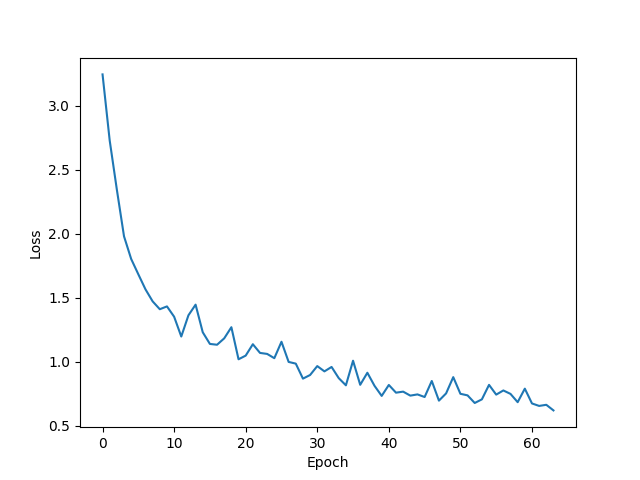

In [57]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [15]:
# Generate a new test set
n_test = 10240
test3_events, test3_tracks = generate_data(
    n_test, det_shape, seed_size=0,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)
test3_input = np_to_torch(test3_events, volatile=True)
test3_seeds = np_to_torch(test3_tracks[:,:seed_size], volatile=True)
test3_labels = np_to_torch(test3_tracks.argmax(axis=2), volatile=True)

In [59]:
# Inference mode supposedly consumes less memory
model3.eval()

# Calculate test set predictions and loss
test3_outputs = model3([test3_input, test3_seeds])
test3_probs = [logits_to_probs(outputs) for outputs in test3_outputs]
test3_loss = cost_function(test3_outputs, test3_labels, loss_weights)
print('Test set loss', test3_loss.data[0])

# Compute forward prediction accuracy
print('Forward prediction accuracies')
print('  pixel', calc_accuracy(test3_probs[0], test3_labels))
print('  hit  ', calc_accuracy(test3_input * test3_probs[0], test3_labels))

print('Final prediction accuracies')
print('  pixel', calc_accuracy(test3_probs[1], test3_labels))
print('  hit  ', calc_accuracy(test3_input * test3_probs[1], test3_labels))

Test set loss 0.578407943249
Forward prediction accuracies
  pixel 0.717646484375
  hit   0.916115234375
Final prediction accuracies
  pixel 0.9151328125
  hit   0.91921484375


<IPython.core.display.Javascript object>


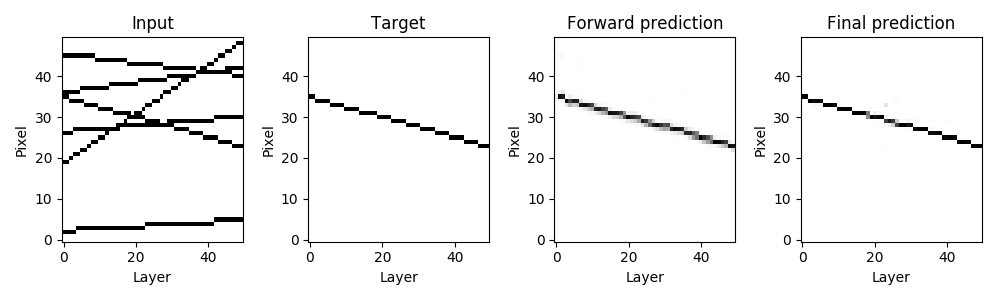

<IPython.core.display.Javascript object>


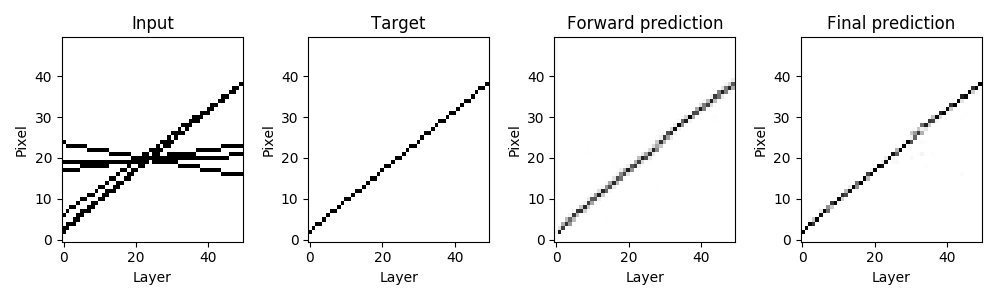

<IPython.core.display.Javascript object>


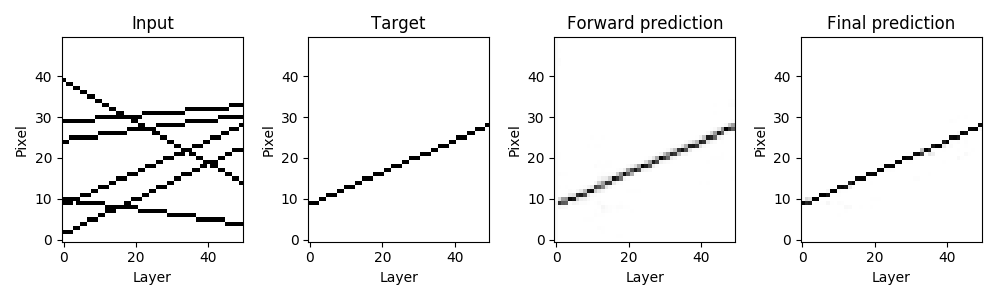

In [60]:
for i in [0, 1, 2]:
    plt.figure(figsize=(10,3))
    plt.subplot(141)
    draw_2d_event(test3_events[i], title='Input', cmap='gray_r')
    plt.subplot(142)
    draw_2d_event(test3_tracks[i], title='Target', cmap='gray_r')
    plt.subplot(143)
    draw_2d_event(torch_to_np(test3_probs[0][i]), title='Forward prediction', cmap='gray_r')
    plt.subplot(144)
    draw_2d_event(torch_to_np(test3_probs[1][i]), title='Final prediction', cmap='gray_r')

### Discussion

This model can clearly learn and perform well on this toy data, but it takes a _lot_ of training to get to good performance. Note in the above session it hasn't fully converged. Maybe there are ways to speed it up, but it's a little tough to believe that for a fixed amount of data this model can outperform the simpler lstm model. Still, I think this approach has very nice motivations and might be more useful in more complex scenarios.

This model could be trained in more complicated ways which may improve the experience:
- The loss weights on forward-vs-final prediction could be adjusted during training.
- The extrapolator module could be pre-trained.